<a href="https://colab.research.google.com/github/kevinwatkins/deep-learning-sandbox/blob/master/eleutherai/EleutherAI_training_overview.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [31]:
import io, re, ast, requests, json, numpy as np, matplotlib.pyplot as plt, matplotlib.image as mpimg
openai_image = None

## Tensorboard list

In [2]:
runs = np.array([
    'run-2',
    'run-3',
    'gpt3-xl-replication-1',

    'gpt3-small',
    'gpt3-175b',
])
# (url_stem, run_stem)
tensorboards = {
    'run-2': ('http://35.204.253.196:8106', ''),
    'run-3': ('http://35.204.253.196:8110', 'false/'),
    'gpt3-xl-replication-1': ('http://35.204.253.196:8042', ''),
}

## Hyperparameters

Presently the hyperparameters are given in a cell here. Some OpenAI GPT-3 models are included for comparison.

In [3]:
hparams = json.loads('''{

"run-2": {
    "n_head": 8,
    "n_vocab": 32768,
    "embed_dropout": 0.1,
    "lr": 0.0006,
    "warmup_steps": 3000,
    "beta1": 0.9,
    "beta2": 0.95,
    "epsilon": 1e-8,
    "opt_name": "adam",
    "weight_decay": 0.1,
    "lr_decay": "linear",
    "train_batch_size": 32,
    "attn_dropout": 0.1,
    "train_steps": 300000,
    "eval_steps": 0,
    "res_dropout": 0.1,
    "eval_batch_size": 32,
    "iterations": 500,
    "n_embd": 768,
    "datasets": [["gs://neo-datasets/openwebtext-new/openwebtext_*.tfrecords", "", 11, "documents_random", 1.0]],
    "model": "GPT2",
    "model_path": "gs://neo-models/Global_long_Benchmark",
    "n_ctx": 1024,
    "n_layer": 12,
    "scale_by_depth": true,
    "scale_by_in": true,
    "local": false,
    "mesh_shape": "all:8",
    "layout": "heads:all",
    "precision": "float32",
    "activation_function": "gelu",
    "microbatches_per_batch": 1
},

"run-3": {
    "n_head": 8,
    "n_vocab": 32768,
    "embed_dropout": 0.1,
    "lr": 0.0006,
    "warmup_steps": 3000,
    "beta1": 0.9,
    "beta2": 0.95,
    "epsilon": 1e-8,
    "opt_name": "adam",
    "weight_decay": 0.1,
    "lr_decay": "linear",
    "train_batch_size": 32,
    "attn_dropout": 0.1,
    "train_steps": 300000,
    "eval_steps": 0,
    "res_dropout": 0.1,
    "eval_batch_size": 32,
    "iterations": 500,
    "n_embd": 768,
    "datasets": [["gs://neo-datasets/openwebtext-new/openwebtext_*.tfrecords", "", 11, "documents_random", 1.0]],
    "model": "GPT2",
    "model_path": "gs://neo-models/cursed-false",
    "n_ctx": 1024,
    "n_layer": 12,
    "scale_by_depth": true,
    "scale_by_in": true,
    "local": false,
    "mesh_shape": "all:8",
    "layout": "heads:all",
    "precision": "float32",
    "activation_function": "gelu",
    "microbatches_per_batch": 1
},

"gpt3-small": {
    "train_batch_size": 250,
    "train_steps": 585938,
    "n_head": 12,
    "n_vocab": 50257,
    "n_layer": 12,
    "n_embd": 768,
    "n_ctx": 2048,
    "mesh_shape": "dummy:1"
},

"gpt3-175b": {
    "train_batch_size": 1600,
    "train_steps": 91553,
    "n_head": 96,
    "n_vocab": 50257,
    "n_layer": 96,
    "n_embd": 12288,
    "n_ctx": 2048,
    "mesh_shape": "dummy:1"
}

}''')

## Data loading

The last cell in this section will attempt to load data from all the tensorboards and create (or overwrite) local copies. The rest of the notebook operates on the local copies.

In [4]:
def run_hparams_path(run):
    return f'{run}-hparams.json'
def run_data_path(run):
    return f'{run}.json'

In [29]:
def get_hparams(run):
    if run in hparams:
        return hparams[run]
    url_stem, run_stem = tensorboards[run]
    url = f'{url_stem}/data/plugin/text/text'
    try:
        resp = requests.get(url, params={
            'tag': 'run_config',
            'run': f'{run_stem}config',
        })
        resp.raise_for_status()

        # wheeeeeeeeeee
        json1 = resp.json()
        text1 = json1[0]['text']
        text2 = re.sub('<p>(.*)</p>', '\\1', text1)
        return ast.literal_eval(text2)
    except:
        return None

def get_run_data(run):
    url_stem, run_stem = tensorboards[run]
    url = f'{url_stem}/data/plugin/scalars/scalars'
    try:
        resp = requests.get(url, params={
            'tag': 'loss',
            'run': f'{run_stem}.',
            'experiment': '',
        })
        resp.raise_for_status()
        return resp.text
    except:
        return None

def update_hparams(run):
    hparams = get_hparams(run)
    if hparams:
        with open(run_hparams_path(run), 'w') as f:
            f.write(json.dumps(hparams))
        print(f'refreshed {run} hparams')
    else:
        print(f'no luck refreshing {run} hparams')

def update_run_data(run):
    data = get_run_data(run)
    if data:
        with open(run_data_path(run), 'w') as f:
            f.write(data)
        print(f'refreshed {run}')
    else:
        print(f'no luck refreshing {run}')

In [33]:
for run in runs:
    if run in tensorboards and run not in hparams:
        update_hparams(run)
    if run in tensorboards:
        update_run_data(run)

refreshed run-2
refreshed run-3
refreshed gpt3-xl-replication-1 hparams
no luck refreshing gpt3-xl-replication-1


## Reformatting data as numpy arrays

In [34]:
def load_hparams(run):
    if run in hparams:
        return hparams[run]
    with open(run_hparams_path(run), 'r') as f:
        return json.load(f)
def load_run_data(run):
    try:
        with open(run_data_path(run), 'r') as f:
            return json.load(f)
    except:
        return []
run_hparams_dict = {run: load_hparams(run) for run in runs}
run_data_list = [load_run_data(run) for run in runs]

In [35]:
def hparray(key):
    return np.array([run_hparams_dict[run][key] for run in runs])

In [36]:
train_batch_size = hparray('train_batch_size')
n_head = hparray('n_head')
n_vocab = hparray('n_vocab')
n_layer = hparray('n_layer')
n_embd = hparray('n_embd')
n_ctx = hparray('n_ctx')
mesh_shape = hparray('mesh_shape')
train_steps = hparray('train_steps')

In [37]:
n_rows = np.array([len(d) for d in run_data_list])
run_data = np.full([len(runs), max(n_rows), 3], np.nan)
for i in range(len(runs)):
    data = run_data_list[i]
    if len(data) > 0:
        run_data[i, :len(data), :] = np.array(data)

In [38]:
def get_n_cores(mesh_shape):
    dims = mesh_shape.split(',')
    dim_lens = [int(dim.split(':')[1]) for dim in dims]
    return np.prod(dim_lens)

In [39]:
wall_time = run_data[:, :, 0]
step = run_data[:, :, 1]
loss = run_data[:, :, 2]

## Further calculated quantities

In [43]:
nz_rows = np.nonzero(n_rows)
nz_last_row = n_rows[nz_rows]-1
wall_elapsed = np.full(len(runs), np.nan)
wall_elapsed[nz_rows] = wall_time[nz_rows, nz_last_row] - wall_time[nz_rows, 0]
batches_elapsed = np.full(len(runs), np.nan)
batches_elapsed[nz_rows] = step[nz_rows, nz_last_row] - step[nz_rows, 0]
end_loss = np.full(len(runs), np.nan)
end_loss[nz_rows] = loss[nz_rows, nz_last_row]
flops_per_core = 52.5e12
n_cores = np.array([get_n_cores(shape) for shape in mesh_shape], dtype=float)
total_flops = flops_per_core*n_cores
approx_model_params = n_layer*(n_embd.astype(float)**2)*12 + n_vocab*n_embd.astype(float)
total_train_tokens = train_steps*n_ctx*train_batch_size.astype(float)
total_approx_ops = approx_model_params*total_train_tokens*6
total_pflops_days = total_approx_ops/1e15/86400
train_tokens_elapsed = batches_elapsed*n_ctx*train_batch_size
approx_ops_elapsed = approx_model_params*train_tokens_elapsed*6
pflops_days_elapsed = approx_ops_elapsed/1e15/86400
theo_eff = approx_ops_elapsed/(wall_elapsed*total_flops)
wall_remaining = total_approx_ops/total_flops/theo_eff-wall_elapsed

In [44]:
row_train_tokens = step*n_ctx[:, np.newaxis]*train_batch_size[:, np.newaxis].astype(float)
row_approx_n_ops = approx_model_params[:, np.newaxis]*row_train_tokens*6
row_pflops_days = row_approx_n_ops/1e15/86400

## Model size comparison

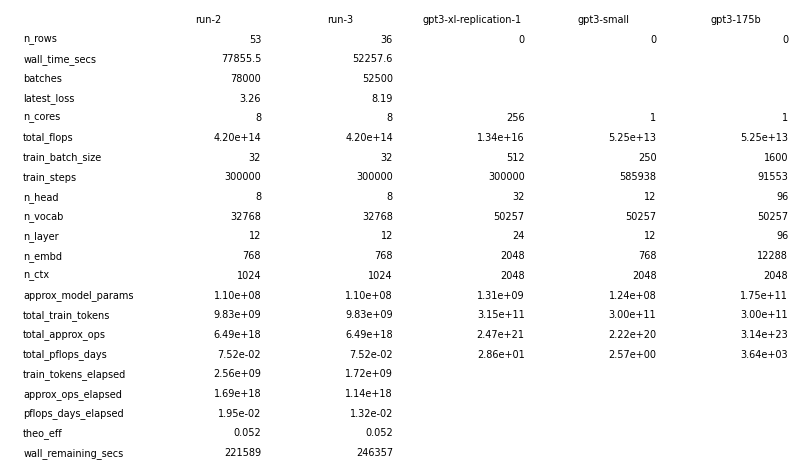

In [52]:
plt.figure(figsize=(1+1.5*len(runs), 6), dpi=100)
plt.axis('off')

row_labels = []
cell_text = []

def format_val(val, format_spec):
    if np.isnan(val):
        return ''
    else:
        return format(val, format_spec)

def add_row(name, values, format_spec=''):
    row_labels.append(name)
    cell_text.append([format_val(v, format_spec) for v in values])

add_row('n_rows', n_rows)
add_row('wall_time_secs', wall_elapsed, '.1f')
add_row('batches', batches_elapsed, '.0f')
add_row('latest_loss', end_loss, '.2f')
add_row('n_cores', n_cores, '.0f')
add_row('total_flops', total_flops, '.2e')
add_row('train_batch_size', train_batch_size)
add_row('train_steps', train_steps)
add_row('n_head', n_head)
add_row('n_vocab', n_vocab)
add_row('n_layer', n_layer)
add_row('n_embd', n_embd)
add_row('n_ctx', n_ctx)
add_row('approx_model_params', approx_model_params, '.2e')
add_row('total_train_tokens', total_train_tokens, '.2e')
add_row('total_approx_ops', total_approx_ops, '.2e')
add_row('total_pflops_days', total_pflops_days, '.2e')
add_row('train_tokens_elapsed', train_tokens_elapsed, '.2e')
add_row('approx_ops_elapsed', approx_ops_elapsed, '.2e')
add_row('pflops_days_elapsed', pflops_days_elapsed, '.2e')
add_row('theo_eff', theo_eff, '.3f')
add_row('wall_remaining_secs', wall_remaining, '.0f')

plt.table(rowLabels=row_labels, colLabels=runs, cellText=cell_text, loc='center',
          bbox=(0, 0, 1, 1), edges='open')
plt.show()

## Loss vs compute plot

Note: the "compute" axis is the theoretical pflops-days that would be consumed if the tensor operations could be run at 100% efficiency. In practice, the actual pflops-days will be greater. Also, the number of floating point operations is only approximated here.

Note 2: As of this writing, EleutherAI is using its own BPE vocabulary, so in theory, losses from EleutherAI and OpenAI cannot be directly compared.

In [ ]:
show_openai_runs = True

### Implementation details

In [ ]:
def download_openai_image():
    try:
        resp = requests.get('https://storage.googleapis.com/via-whereas/LanguageModelingComputePareto.png')
        resp.raise_for_status()
        return resp.content
    except:
        return None

In [ ]:
def show_loss_compute_plot():
    global openai_image
    fig = plt.figure(figsize=(6.37, 6), dpi=100)

    if show_openai_runs:
        fig.add_subplot(label='image')
        if not openai_image:
            openai_image = download_openai_image()
        img = mpimg.imread(io.BytesIO(openai_image))
        plt.imshow(img[112:1520, 380:1912])
        plt.axis('off')

    ax = fig.add_subplot(label='runs')
    ax.patch.set_alpha(0)

    for i in range(len(runs)):
        plt.plot(row_pflops_days[i, :n_rows[i]], loss[i, :n_rows[i]], 'r')

    if not show_openai_runs:
        frontier_xs = np.array([1e-6, 1e4])
        frontier_ys = 2.57*(frontier_xs**-0.048)
        plt.plot(frontier_xs, frontier_ys, 'k:')

    plt.xlabel('Compute (pflops-days)')
    plt.xscale('log')
    plt.xlim(1e-6, 1e4)
    plt.xticks(10.**np.arange(-6, 6, 2))

    plt.ylabel('Loss')
    plt.yscale('log')
    plt.ylim(1.5, 6)
    y_ticks = [1.5] + list(range(2, 7))
    plt.yticks(y_ticks, labels=[str(t) for t in y_ticks])

    plt.grid(not show_openai_runs)
    plt.show()

### The plot

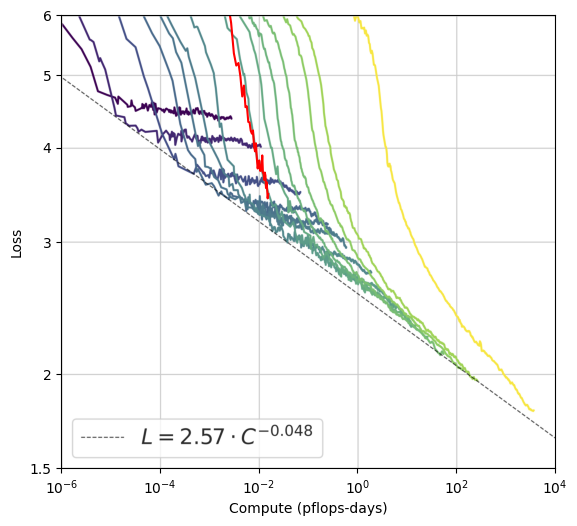

In [ ]:
show_loss_compute_plot()